In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt

In [2]:
# Load dataset
df = pd.read_csv("car_price_prediction.csv")
df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [3]:
# Feature Engineering
df["Car_Age"] = 2025 - df["Prod. year"]
df.drop(columns=['ID', 'Model', 'Levy', 'Model', 'Doors', 'Wheel'], inplace=True)

#df = df.drop(columns=["ID", "Model"])


# Clean up lines with words in int values "Turbo, km, etc."
#df["Levy"] = df["Levy"].replace("-", "0")
#df["Levy"] = df["Levy"].str.replace(",", "").astype(float)
df["Mileage"] = df["Mileage"].str.replace(" km", "").str.replace(",", "").astype(float)
df["Engine volume"] = df["Engine volume"].str.replace(" Turbo", "").str.replace("L", "").astype(float)
df["Leather interior"] = df["Leather interior"].map({"Yes": 1, "No": 0})
df["Cylinders"] = pd.to_numeric(df["Cylinders"], errors="coerce")
df["Airbags"] = pd.to_numeric(df["Airbags"], errors="coerce")


In [4]:
# Remove Outliers
df = df[(df["Price"] >= 7000) & (df["Price"] <= 90000)]

# Drop missing values
df = df.dropna()
df.head()

,Price,Manufacturer,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Color,Airbags,Car_Age
0,13328,LEXUS,2010,Jeep,1,Hybrid,3.5,186005.0,6.0,Automatic,4x4,Silver,12,15
1,16621,CHEVROLET,2011,Jeep,0,Petrol,3.0,192000.0,6.0,Tiptronic,4x4,Black,8,14
2,8467,HONDA,2006,Hatchback,0,Petrol,1.3,200000.0,4.0,Variator,Front,Black,2,19
4,11726,HONDA,2014,Hatchback,1,Petrol,1.3,91901.0,4.0,Automatic,Front,Silver,4,11
5,39493,HYUNDAI,2016,Jeep,1,Diesel,2.0,160931.0,4.0,Automatic,Front,White,4,9


In [5]:
# Split into features (X) and target (y)
X = df.drop("Price", axis=1)
y = np.log1p(df["Price"])

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Preprocessing
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [7]:
# Random Forest pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(random_state=42))
])

In [8]:
# Hyperparameter tuning
param_grid = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [10, 15, 20],
    "model__min_samples_split": [2, 5, 10]
}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring="neg_mean_absolute_error")


In [9]:
# Train
grid_search.fit(X_train, y_train)

# Best model
y_pred = np.expm1(grid_search.best_estimator_.predict(X_test))

# Evaluation
mae = mean_absolute_error(np.expm1(y_test), y_pred)
r2 = r2_score(np.expm1(y_test), y_pred)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Random Forest - Mean Absolute Error: {mae:.2f}")
print(f"Random Forest - R² Score: {r2:.2f}")

Best Parameters: {'model__max_depth': 20, 'model__min_samples_split': 2, 'model__n_estimators': 300}
Random Forest - Mean Absolute Error: 4085.03
Random Forest - R² Score: 0.76


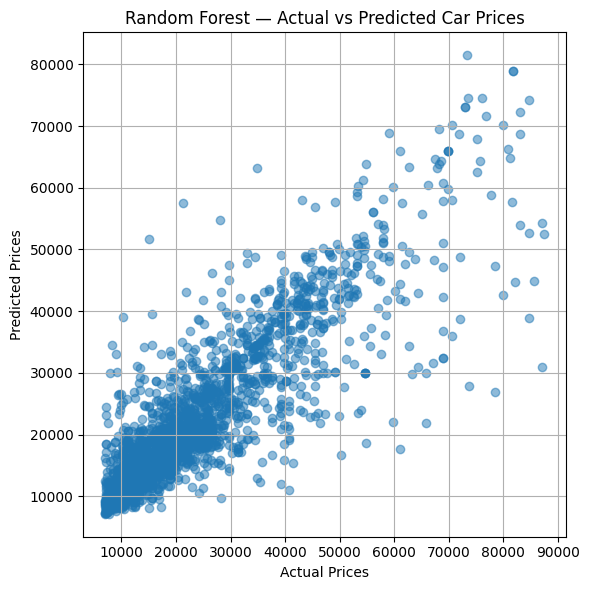

In [10]:
# Plot results
plt.figure(figsize=(6, 6))
plt.scatter(np.expm1(y_test), y_pred, alpha=0.5)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Random Forest — Actual vs Predicted Car Prices")
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
# Baseline
baseline_pred = [np.expm1(y_train).mean()] * len(y_test)
baseline_mae = mean_absolute_error(np.expm1(y_test), baseline_pred)
print(f"Baseline Mean Absolute Error (predicting mean price): {baseline_mae:.2f}")

Baseline Mean Absolute Error (predicting mean price): 10660.61



Feature Importance:


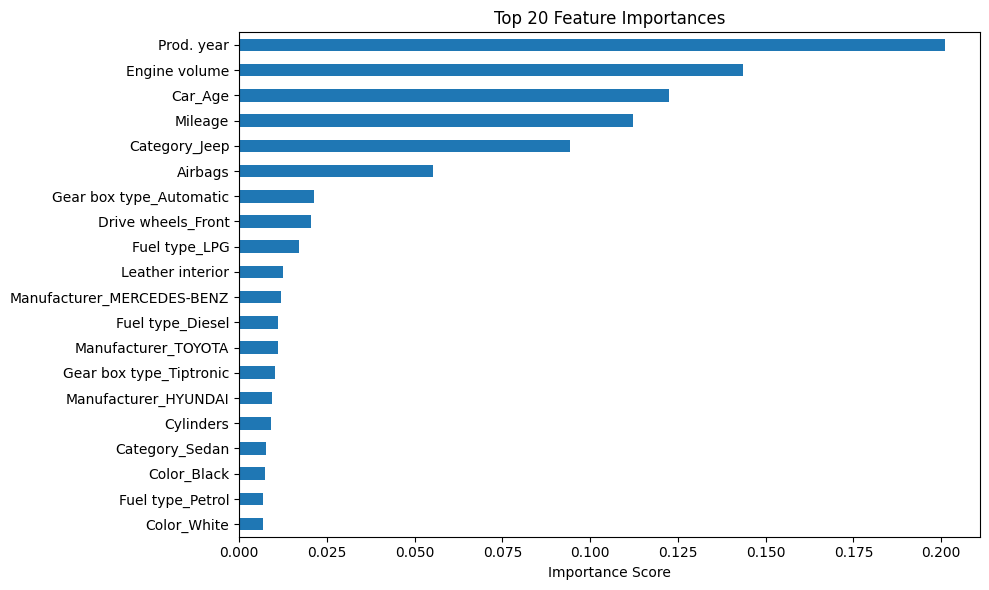

In [12]:
print("\nFeature Importance:")

# Get the model and preprocessor
best_model = grid_search.best_estimator_.named_steps["model"]
preprocessor = grid_search.best_estimator_.named_steps["preprocessor"]

# Get numeric and one-hot feature names
numeric_feature_names = list(numeric_features)

onehot = preprocessor.named_transformers_["cat"].named_steps["onehot"]
onehot_feature_names = list(onehot.get_feature_names_out(categorical_features))

# Full feature list after transformation
all_features = numeric_feature_names + onehot_feature_names

# Get feature importances
importances = best_model.feature_importances_

# Create a Series and plot top 20
feature_importance = pd.Series(importances, index=all_features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feature_importance.head(20).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.inspection import PartialDependenceDisplay

# Partial dependence plot for one feature
PartialDependenceDisplay.from_estimator(
    grid_search.best_estimator_,
    X_test,
    features=["Mileage"],  # or "Mileage", "Engine volume", etc
    kind="average"
)
plt.show()
